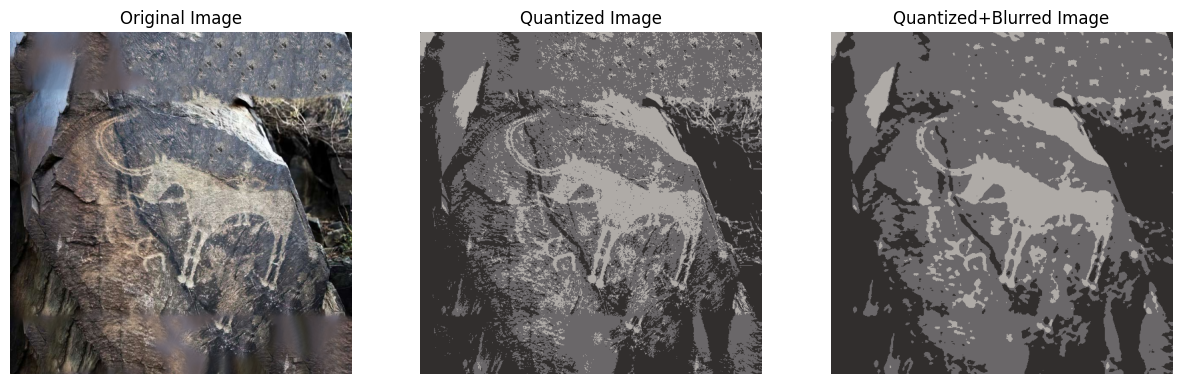

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('augmented_data/1.png')

pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

k = 3

ret, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)

quantized_image = centers[labels.flatten()]

quantized_image = quantized_image.reshape((image.shape))

median_blurred_image = cv2.medianBlur(quantized_image, 5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Quantized Image')
plt.imshow(cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Quantized+Blurred Image')
plt.imshow(cv2.cvtColor(median_blurred_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [3]:
def unsupervised_segmentation(image, k, spatial_weight=1.0):
    """
    Performs unsupervised segmentation using K-Means on color and spatial features.
    
    Args:
        image (np.array): The input BGR image.
        k (int): The number of desired segments (clusters).
        spatial_weight (float): How much to weight the pixel coordinates. Tune this value.
    
    Returns:
        The segmented image.
    """
    h, w, _ = image.shape

    # --- 1. Create the Feature Vector ---
    # Reshape the image to a list of pixels (N, 3)
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)

    # Create the (x, y) coordinates for each pixel
    # np.mgrid creates two grids, one for y-coordinates and one for x-coordinates
    yy, xx = np.mgrid[0:h, 0:w]
    
    # Reshape the coordinate grids to be single columns
    xy_features = np.stack((xx.flatten(), yy.flatten()), axis=1)
    
    # Apply the spatial weight. This balances color vs. position.
    # We normalize coordinates to be roughly in the same range as colors.
    xy_features = np.float32(xy_features) * spatial_weight * (255 / max(h, w))
    
    # Concatenate color features and spatial features
    # Each pixel is now represented by (B, G, R, X, Y)
    features = np.concatenate((pixels, xy_features), axis=1)

    # --- 2. Apply K-Means Clustering ---
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, labels, centers = cv2.kmeans(features, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # --- 3. Reconstruct the Segmented Image ---
    # The 'centers' now have 5 dimensions. We only care about the first 3 (the color part).
    quantized_colors = np.uint8(centers[:, :3])
    
    # Map each label to its corresponding color
    quantized_image = quantized_colors[labels.flatten()]
    
    # Reshape the image back to its original dimensions
    quantized_image = quantized_image.reshape((image.shape))
    
    return labels, centers, quantized_image

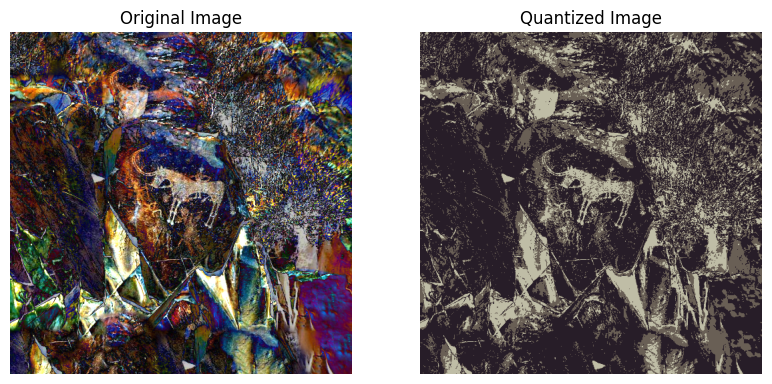

In [4]:
image = cv2.imread('augmented_data/6.png')

alpha = 2.5
beta = -200

image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)

labels, centers, quantized_image = unsupervised_segmentation(image, k = 3, spatial_weight=0.0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Quantized Image')
plt.imshow(cv2.cvtColor(quantized_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

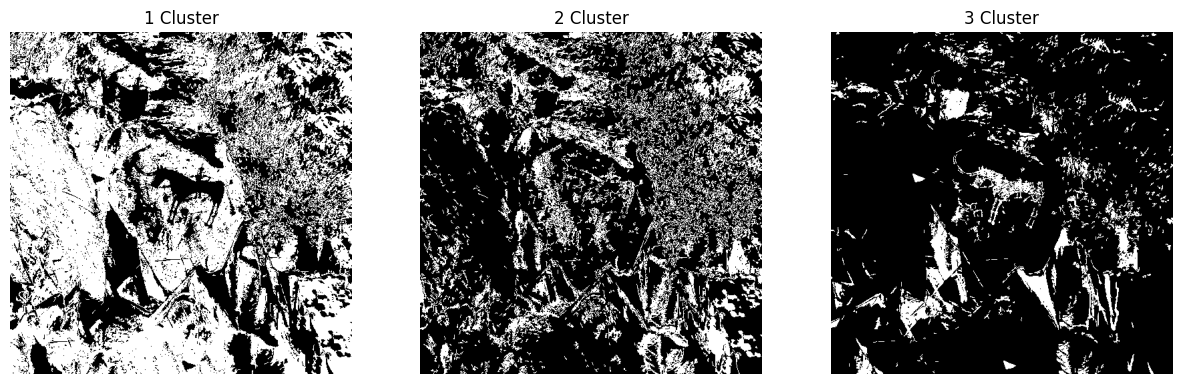

In [5]:
min_area_threshold = 5

cluster_to_display = 0 
mask = np.uint8(labels.flatten() == cluster_to_display) * 255
mask = mask.reshape(image.shape[:2])

num_labels, labels_map, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

mask = np.zeros_like(mask)

for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
            mask[labels_map == i] = 255
first_cluster_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

cluster_to_display = 1
mask = np.uint8(labels.flatten() == cluster_to_display) * 255
mask = mask.reshape(image.shape[:2])

num_labels, labels_map, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

mask = np.zeros_like(mask)

for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
            mask[labels_map == i] = 255

second_cluster_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

cluster_to_display = 2
mask = np.uint8(labels.flatten() == cluster_to_display) * 255
mask = mask.reshape(image.shape[:2])

num_labels, labels_map, stats, centroids = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

mask = np.zeros_like(mask)

for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold:
            mask[labels_map == i] = 255
third_cluster_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('1 Cluster')
plt.imshow(cv2.cvtColor(first_cluster_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('2 Cluster')
plt.imshow(cv2.cvtColor(second_cluster_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('3 Cluster')
plt.imshow(cv2.cvtColor(third_cluster_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [8]:
import torch.nn.functional as F
from diffusers import StableDiffusionXLInpaintPipeline, StableDiffusion3InpaintPipeline, StableDiffusion3Img2ImgPipeline 

In [ ]:
class AttentionStore:
    def __init__(self, target_res=32):
        print(f"AttentionStore initialized to target a resolution of {target_res}x{target_res}.")
        self.target_res = target_res
        self.attention_maps = []

    def __call__(self, attn, hidden_states, encoder_hidden_states=None, attention_mask=None, **kwargs):
        is_cross_attention = encoder_hidden_states is not None
        
        key_value_source = encoder_hidden_states if is_cross_attention else hidden_states

        query = attn.to_q(hidden_states)
        key = attn.to_k(key_value_source)
        value = attn.to_v(key_value_source)
        
        query_res = int(np.sqrt(query.shape[1]))

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)

        if is_cross_attention and query_res == self.target_res:
            self.attention_maps.append(attention_probs.cpu())

        hidden_states = F.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )
        hidden_states = attn.batch_to_head_dim(hidden_states)
        hidden_states = attn.to_out[0](hidden_states)
        hidden_states = attn.to_out[1](hidden_states)

        return hidden_states

    def reset(self):
        self.attention_maps = []


def diffcut_segmentation(image, text_prompt, pipe=None, num_inference_steps=20, guidance_scale=7.5, threshold=0.15, target_res=32):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    attention_store = AttentionStore(target_res=target_res)
    pipe.unet.set_attn_processor(attention_store)

    width, height = image.size
    dummy_mask = Image.new("L", (width, height), 0)

    print("Running diffusion process to capture attention...")
    generator = torch.Generator(device).manual_seed(42)
    text_inputs = pipe.tokenizer(text_prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
    prompt_token_indices = torch.where(text_inputs.input_ids[0] != pipe.tokenizer.pad_token_id)[0]
    
    pipe(
        prompt=text_prompt, image=image, mask_image=dummy_mask,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=generator
    )

    print("Aggregating and processing attention maps...")
    
    if not attention_store.attention_maps:
        raise ValueError(f"No attention maps were captured for the target resolution {target_res}x{target_res}. Try another resolution (e.g., 16 or 64).")

    avg_attention_map = torch.cat(attention_store.attention_maps, dim=0).mean(dim=0)
    object_attention = avg_attention_map[:, prompt_token_indices[1:-1]].mean(dim=-1)

    map_res = int(np.sqrt(object_attention.shape[0]))
    object_attention = object_attention.reshape(map_res, map_res)
    
    final_attention_map = F.interpolate(
        object_attention.unsqueeze(0).unsqueeze(0),
        size=(height, width), mode='bicubic', align_corners=False
    ).squeeze().float()

    final_attention_map = (final_attention_map - final_attention_map.min()) / (final_attention_map.max() - final_attention_map.min())
    
    binary_mask = (final_attention_map > threshold).cpu().numpy().astype(np.uint8)
    segmented_image = np.array(image) * binary_mask[:, :, np.newaxis]
    if np.sum(binary_mask) == 0:
        largest_component_mask = binary_mask
    else:
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)

        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

        largest_component_mask = np.zeros(binary_mask.shape, dtype=np.uint8)
        largest_component_mask[labels == largest_label] = 1


    segmented_image_largest_part = np.array(image) * largest_component_mask[:, :, np.newaxis]
    
    return final_attention_map.cpu().numpy(), Image.fromarray(segmented_image_largest_part)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to(device)

Using device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


In [18]:
object_prompts = [
            "a photo of an ancient animal carving on a dark rock",
            "a stylized drawing of an ibex etched into stone",
            "a light-colored engraving on a dark, textured surface"
        ]
background_prompt = "a photo of a rough, dark, cracked rock face"

In [19]:
IMAGE_URL = "augmented_data/1.png"
TEXT_PROMPT =  "a petroglyph carving on a rock" 
THRESHOLD = 0.5

Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:21<00:00,  1.14s/it]


Aggregating and processing attention maps...


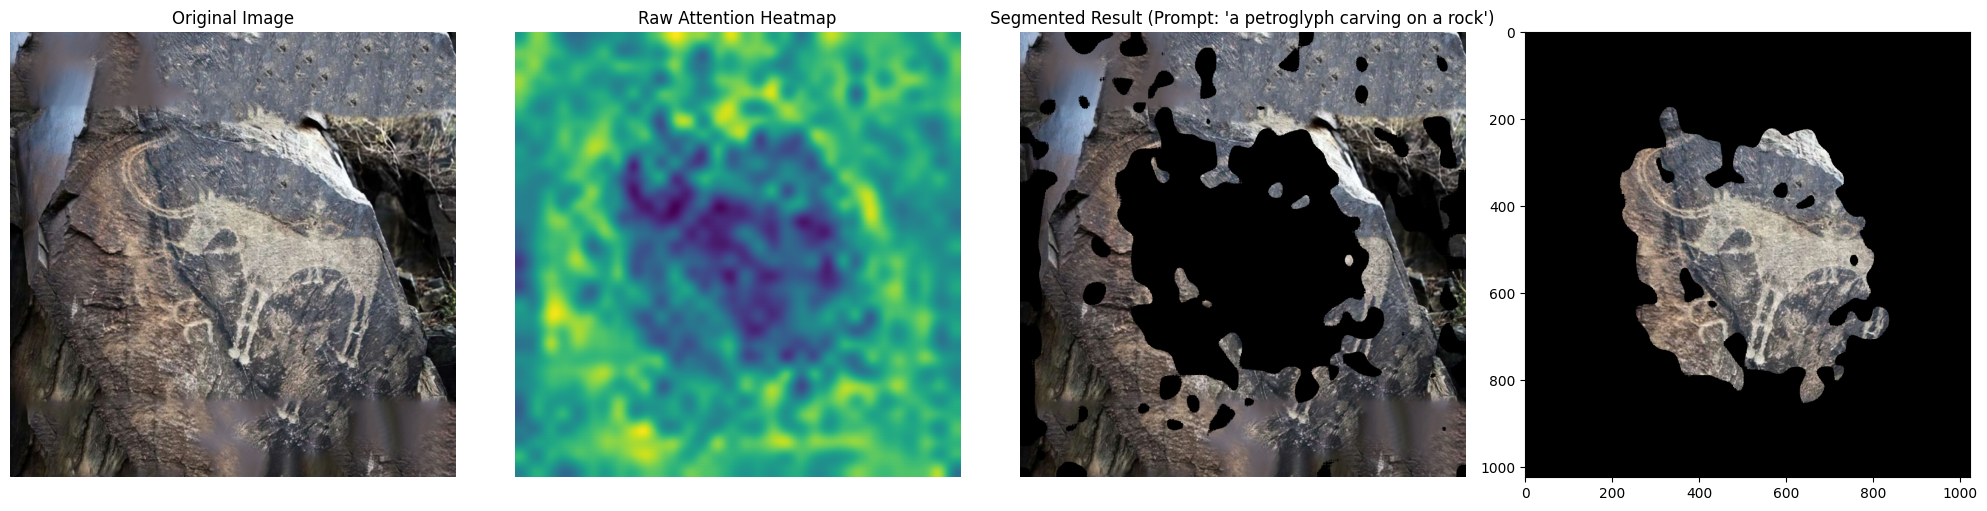

In [20]:
input_image = Image.open(IMAGE_URL).convert("RGB").resize((1024, 1024))
        
attention_heatmap, segmented_result = diffcut_segmentation(
    image=input_image, text_prompt=TEXT_PROMPT, threshold=THRESHOLD, target_res=32, pipe=pipe, guidance_scale=8.5, num_inference_steps=20
)
inverted_heatmap = 1.0 - attention_heatmap
inverted_mask = (inverted_heatmap > (1-THRESHOLD)).astype(np.uint8)
inverted_segmented_image = np.array(input_image) * inverted_mask[:, :, np.newaxis]
        
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
ax[0].imshow(input_image); ax[0].set_title("Original Image"); ax[0].axis("off")
ax[1].imshow(inverted_heatmap, cmap='viridis'); ax[1].set_title("Raw Attention Heatmap"); ax[1].axis("off")
ax[2].imshow(inverted_segmented_image); ax[2].set_title(f"Segmented Result (Prompt: '{TEXT_PROMPT}')"); ax[2].axis("off")
ax[3].imshow(segmented_result); ax[2].set_title(f"Segmented Result (Prompt: '{TEXT_PROMPT}')"); ax[2].axis("off")
plt.tight_layout(); plt.show()

In [21]:
for i in range(76):
    IMAGE_URL = f"augmented_data/{i+1}.png"
    input_image = Image.open(IMAGE_URL).convert("RGB").resize((1024, 1024))
        
    attention_heatmap, segmented_result = diffcut_segmentation(
        image=input_image, text_prompt=TEXT_PROMPT, threshold=THRESHOLD, target_res=32, pipe=pipe, guidance_scale=8.5, num_inference_steps=20
    )
    inverted_heatmap = 1.0 - attention_heatmap
    inverted_mask = (inverted_heatmap > (1-THRESHOLD)).astype(np.uint8)
    inverted_segmented_image = np.array(input_image) * inverted_mask[:, :, np.newaxis]
    
    segmented_result.save(f"pre_segmented_results/segmented_{i+1}.png")

Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:21<00:00,  1.13s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:19<00:00,  1.03s/it]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.19it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.24it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.19it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.18it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


Aggregating and processing attention maps...
Using device: cuda
AttentionStore initialized to target a resolution of 32x32.
Running diffusion process to capture attention...


100%|██████████| 19/19 [00:16<00:00,  1.16it/s]


Aggregating and processing attention maps...
